In [140]:
import numpy as np
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from PIL import Image
from typing import List
import pennylane as qml
from zprop import propagator

def load_and_downsample_mnist(side=14):
    # Load the MNIST dataset
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    
    # Normalize the images
    X_train = X_train.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0
    
    # Function to resize images
    def resize_images(images, size):
        resized_images = np.array([
            np.array(Image.fromarray(img).resize((size, size)))
            for img in images
        ])
        return resized_images
    
    # Downsample images
    X_train_resized = resize_images(X_train, side)
    X_test_resized = resize_images(X_test, side)
    
    return X_train_resized, y_train, X_test_resized, y_test
    


In [59]:
def flatten(X, sub_size = 2):
    side = np.shape(X)[0]

    flattened = []

    # Loop through the image in sub-square blocks
    for start_row in range(0, side, sub_size):
        for start_col in range(0, side, sub_size):
            for i in range(sub_size):
                for j in range(sub_size):
                    # Check if within bounds
                    if start_row + i < side and start_col + j < side:
                        flattened.append(X[start_row + i, start_col + j])
    
    return np.array(flattened)


In [60]:
def show_img(idx):
    plt.figure(figsize=(3,3))
    # Plot the first downsampled image
    plt.imshow(X_train[idx], cmap='gray')
    plt.title(f'Label: {y_train[idx]}')
    plt.axis('off')
    plt.show()

In [127]:
def wall_gate(
    active_wires: List[int],
    gate: qml.operation.Operator,
    params = [],
    index: int = 0,
    samerot: bool = False,
) -> int:
    if len(params) > 0:
        if not samerot:
            for i, spin in enumerate(active_wires):
                gate(params[index + i], wires=int(spin))
            return index + i + 1
        else:
            for spin in active_wires:
                gate(params[index], wires=int(spin))
            return index + 1
    else:
        for spin in active_wires:
            gate(wires=int(spin))
        return index
    
def wall_cgate_serial(
    active_wires: List[int],
    cgate,
    params = [],
    index: int = 0,
    going_down: bool = True,
) -> int:
    if len(params) > 0:
        for i, (spin, spin_next) in enumerate(zip(active_wires, active_wires[1:])):
            if going_down:
                cgate(params[index + i], wires=[int(spin), int(spin_next)])
            else:
                cgate(params[index + i], wires=[int(spin_next), int(spin)])
        return index + i + 1
    else:
        for spin, spin_next in zip(active_wires, active_wires[1:]):
            if going_down:
                cgate(wires=[int(spin), int(spin_next)])
            else:
                cgate(wires=[int(spin_next), int(spin)])
        return index

def pooling(
    active_wires: List[int],
):
    isodd = True
    if len(active_wires) % 2 == 0:
        isodd = False
    for wire_meas, wire_next in zip(active_wires[0::2], active_wires[1::2]):
        # Removing measured wires from active_wires:
        active_wires = np.delete(active_wires, np.where(active_wires == wire_meas))

    return active_wires


def convolution(active_wires: List[int], params, index: int = 0) -> int:
    if len(active_wires) > 1:
        # Rotation Groups 2
        for wire1, wire2 in zip(active_wires[0::2], active_wires[1::2]):
            qml.RX(params[index], wires=int(wire1))
            qml.RX(params[index], wires=int(wire2))
            index += 1

        if len(active_wires) % 2 != 0:
            qml.RX(params[index], wires=int(active_wires[-1]))
            index += 1

        # CNOTS Groups 1
        for wire1, wire2 in zip(active_wires[1::2], active_wires[2::2]):
            qml.CNOT(wires=[int(wire1), int(wire2)])

        qml.Barrier()

        # Rotation Groups 1
        qml.RY(params[index], wires=int(active_wires[0]))
        index += 1
        for wire1, wire2 in zip(active_wires[1::2], active_wires[2::2]):
            qml.RX(params[index], wires=int(wire1))
            qml.RX(params[index], wires=int(wire2))
            index += 1

        if len(active_wires) % 2 == 0:
            qml.RY(params[index], wires=int(active_wires[-1]))
            index += 1

        # CNOTS Groups 2
        for wire1, wire2 in zip(active_wires[0::2], active_wires[1::2]):
            qml.CNOT(wires=[int(wire1), int(wire2)])

        index = wall_gate(active_wires, qml.RY, params, index)

    return index

In [128]:
def get_active_wires(n_qubit, n_meas):
    active_wires = np.arange(n_qubit)
    while len(active_wires) > 10:  # Repeat until the number of active wires
        # (non measured) is equal to n_outputs
        # Measure wires and apply rotations based on the measurement
        active_wires = pooling(active_wires)
    return active_wires

def qcnn(p_p, p_a, n_qubit, **kwargs):
    def encoding(n_qubit, p_a, index):
        for i in range(n_qubit):
            qml.RX(p_a[index], wires=i)
            index += 1
        return index

    p_index, a_index = 0, 0

    # Wires that are not measured (through pooling)
    active_wires = np.arange(n_qubit)

    # Apply encoding layer
    a_index = encoding(n_qubit, p_a, a_index)

    # Visual Separation State||QCNN
    qml.Barrier()
    qml.Barrier()

    # Iterate Convolution+Pooling until we only have a single wires
    p_index = wall_gate(active_wires, qml.RY, p_p, p_index)
    wall_cgate_serial(active_wires, qml.CNOT)
    while len(active_wires) > 10:  # Repeat until the number of active wires
        # (non measured) is equal to n_outputs
        # Convolute
        p_index = convolution(active_wires, p_p, p_index)
        # Measure wires and apply rotations based on the measurement
        active_wires = pooling(active_wires)

        qml.Barrier()

    wall_cgate_serial(active_wires, qml.CNOT)
    p_index = wall_gate(active_wires, qml.RY, p_p, p_index)

    return p_index, a_index

In [137]:
side = 8
p_meas = get_active_wires(side*side, 10)

In [138]:
p_meas

array([ 7, 15, 23, 31, 39, 47, 55, 63])

In [173]:
X_train_resized, y_train, X_test_resized, y_test = load_and_downsample_mnist(side=8)
# Filter downsampled images where the label is either 0 or 1
X_train = X_train_resized[y_train < len(p_meas)]
y_train = y_train[y_train < len(p_meas)]
x_train = np.array([flatten(x, 5) for x in X_train])

In [158]:
prop_model = propagator.Propagator(n_qubit = 8*8, ansatz = qcnn, k1 = 12, k2=12, p_measured_qubit=p_meas)
prop_model

Propagator
  Number of qubits : 64
  Trainable parameters : 299
  Cutoff 1: 12 | Cutoff 2: 12
 0: ──RX──||──||──RY─╭●──RX────────────────────────────────────────────────────────────────────────
 1: ──RX──||──||──RY─╰X─╭●───RX─────╭●─────────────────────────────────────────────────────────────
 2: ──RX──||──||──RY────╰X──╭●───RX─╰X─────────────────────────────────────────────────────────────
 3: ──RX──||──||──RY────────╰X──╭●───RX─────╭●─────────────────────────────────────────────────────
 4: ──RX──||──||──RY────────────╰X──╭●───RX─╰X─────────────────────────────────────────────────────
 5: ──RX──||──||──RY────────────────╰X──╭●───RX─────╭●─────────────────────────────────────────────
 6: ──RX──||──||──RY────────────────────╰X──╭●───RX─╰X─────────────────────────────────────────────
 7: ──RX──||──||──RY────────────────────────╰X──╭●───RX─────╭●─────────────────────────────────────
 8: ──RX──||──||──RY────────────────────────────╰X──╭●───RX─╰X─────────────────────────────────────
 9: ──

In [159]:
prop_model.to_expr()

                                                    2                         
Z₇ = sin(a₁₁)⋅sin(a₁₃)⋅sin(a₅)⋅sin(a₉)⋅sin(p₁₄₂)⋅sin (p₁₉₄)⋅sin(p₂₂₉)⋅sin(p₂₇₆

                                                                              
)⋅cos(a₁₀)⋅cos(a₂)⋅cos(a₆)⋅cos(a₈)⋅cos(p₁₄₀)⋅cos(p₁₉₃)⋅cos(p₂₁₀)⋅cos(p₂₁₁)⋅cos

                                                                              
(p₂₃₁)⋅cos(p₂₉₁) + sin(a₁₁)⋅sin(a₁₃)⋅sin(a₅)⋅sin(a₉)⋅sin(p₁₄₂)⋅sin(p₁₉₄)⋅sin(p

                                                                              
₂₁₀)⋅sin(p₂₂₉)⋅sin(p₂₇₆)⋅cos(a₁₀)⋅cos(a₂)⋅cos(a₆)⋅cos(a₈)⋅cos(p₁₄₀)⋅cos(p₁₉₃)⋅

                                                                              
cos(p₁₉₄)⋅cos(p₂₁₁)⋅cos(p₂₃₁)⋅cos(p₂₉₁) + sin(a₁₁)⋅sin(a₁₃)⋅sin(p₁₃₆)⋅sin(p₁₃₈

                                                                              
)⋅sin(p₁₄₂)⋅sin(p₂₇₆)⋅cos(a₀)⋅cos(a₁)⋅cos(a₁₀)⋅cos(a₂)⋅cos(a₃)⋅cos(a₄)⋅cos(a₅)

                                              

In [162]:
f,s = prop_model.Hlambdify()

In [170]:
s

'lambda p_p, p_a: [(1.0*jnp.cos(p_p[291])*jnp.cos(p_p[276])*jnp.cos(p_p[267])*jnp.sin(p_p[266])*jnp.sin(p_p[258])*jnp.sin(p_p[227])*jnp.sin(p_p[211])*jnp.cos(p_p[210])*jnp.cos(p_p[210])*jnp.cos(p_p[209])*jnp.cos(p_p[194])*jnp.cos(p_a[7])*jnp.cos(p_a[4])*jnp.cos(p_a[1]) + 1.0*jnp.cos(p_p[291])*jnp.cos(p_p[276])*jnp.cos(p_p[267])*jnp.cos(p_p[266])*jnp.sin(p_p[258])*jnp.sin(p_p[258])*jnp.sin(p_p[211])*jnp.cos(p_p[210])*jnp.sin(p_p[210])*jnp.cos(p_p[209])*jnp.cos(p_p[194])*jnp.cos(p_a[7])*jnp.cos(p_a[4])*jnp.cos(p_a[1]) + -1.0*jnp.sin(p_p[291])*jnp.sin(p_p[278])*jnp.sin(p_p[276])*jnp.cos(p_p[268])*jnp.cos(p_p[267])*jnp.cos(p_p[267])*jnp.cos(p_p[266])*jnp.cos(p_p[259])*jnp.cos(p_p[259])*jnp.cos(p_p[258])*jnp.cos(p_p[233])*jnp.cos(p_a[15])*jnp.cos(p_a[12])*jnp.cos(p_a[9])*jnp.cos(p_a[6])*jnp.cos(p_a[3])*jnp.cos(p_a[0]) + 1.0*jnp.sin(p_p[291])*jnp.sin(p_p[278])*jnp.sin(p_p[276])*jnp.cos(p_p[268])*jnp.sin(p_p[267])*jnp.cos(p_p[267])*jnp.cos(p_p[266])*jnp.cos(p_p[259])*jnp.sin(p_p[259])*jnp.cos

In [174]:
np.shape(x_train[0])

In [203]:
f(p_p=np.random.rand(prop_model.n_p_p), p_a=x_train[0])

[Array(-0.0562109, dtype=float32),
 Array(0.14949714, dtype=float32),
 0,
 0,
 0,
 0,
 Array(-7.634066e-05, dtype=float32),
 Array(-0.01730641, dtype=float32)]

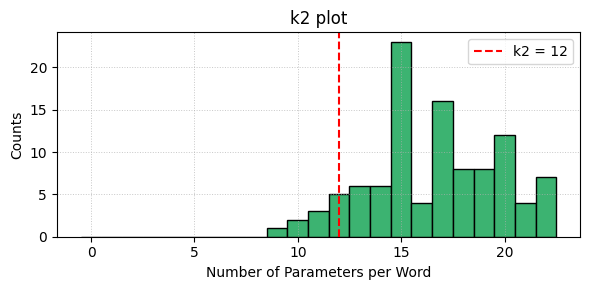

In [160]:
prop_model.plot_k2dist()

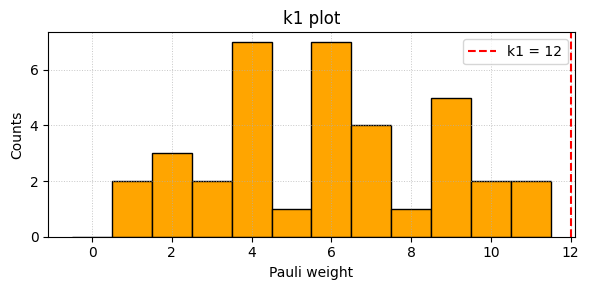

In [161]:
prop_model.plot_k1dist()